In [5]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# Agregar la carpeta 'src' al sys.path
import sys
import os
src_path = "../../src/"
sys.path.append(src_path)
import support_modeling as sp

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("../../data/df_te.csv")
df.sample(5)

,Precio,Tipo de Propiedad,Exterior,Habitaciones,Baños,Provincia,Mostrar Dirección,Tiene Video,Tiene Plano,Tiene 360,Ascensor,Tamaño_robust,Distancia_robust
155,750.0,681.418301,681.49481,689.131332,685.558824,697.296774,680.507463,691.440441,691.007843,706.864550,679.870971,-0.400000,-0.385598
317,690.0,681.418301,681.49481,689.131332,685.558824,697.296774,680.507463,678.348548,677.895197,675.286765,679.870971,0.033333,0.654124
258,750.0,689.034696,681.49481,689.034696,685.558824,697.296774,680.507463,678.348548,677.895197,675.286765,679.870971,-0.800000,-0.524387
311,730.0,681.418301,681.49481,671.204570,685.558824,697.296774,680.507463,691.440441,677.895197,675.286765,684.527919,-0.233333,-0.328613
134,750.0,681.418301,681.49481,671.204570,685.558824,697.296774,688.751480,691.440441,691.007843,675.286765,684.527919,-0.333333,-0.218721


In [7]:
# Creacion de x (variables explicativas) e y (variable respuesta)
x=df.drop("Precio",axis=1)
y=df[["Precio"]]
x_train, x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=42)

In [8]:
# Definición de los hiperparámetros a optimizar
param_grid_rf = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 15, 20, 25],  
    'min_samples_split': [2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10],  
}

# Configuración de GridSearchCV para la optimización de hiperparámetros
model_RandomForestRegressor = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',  
    cv=10,  
    n_jobs=-1,  
)

# Entrenamiento del modelo con la búsqueda de hiperparámetros
model_RandomForestRegressor.fit(x_train, y_train)

best_rf_model = model_RandomForestRegressor.best_estimator_

In [9]:
y_test_pred_rf = best_rf_model.predict(x_test)
y_train_pred_rf = best_rf_model.predict(x_train)
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE
Train,0.856800,21.751800,838.778500,28.961700
Test,0.384900,40.556900,2920.647000,54.043000
Diferenceia Train-Test,0.471900,-18.805100,-2081.868500,-25.081300
Porcentaje diferencia (%),122.603300,-86.453100,-248.202400,-86.601600
Media,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.090829,4.557823,274.998475,6.071717
Influencia dif media (%),0.069000,2.751200,304.573500,3.669300
Mediana,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.087444,4.387937,264.748275,5.845401
Influencia dif mediana (%),0.066500,2.648600,293.220900,3.532600


<!--  -->

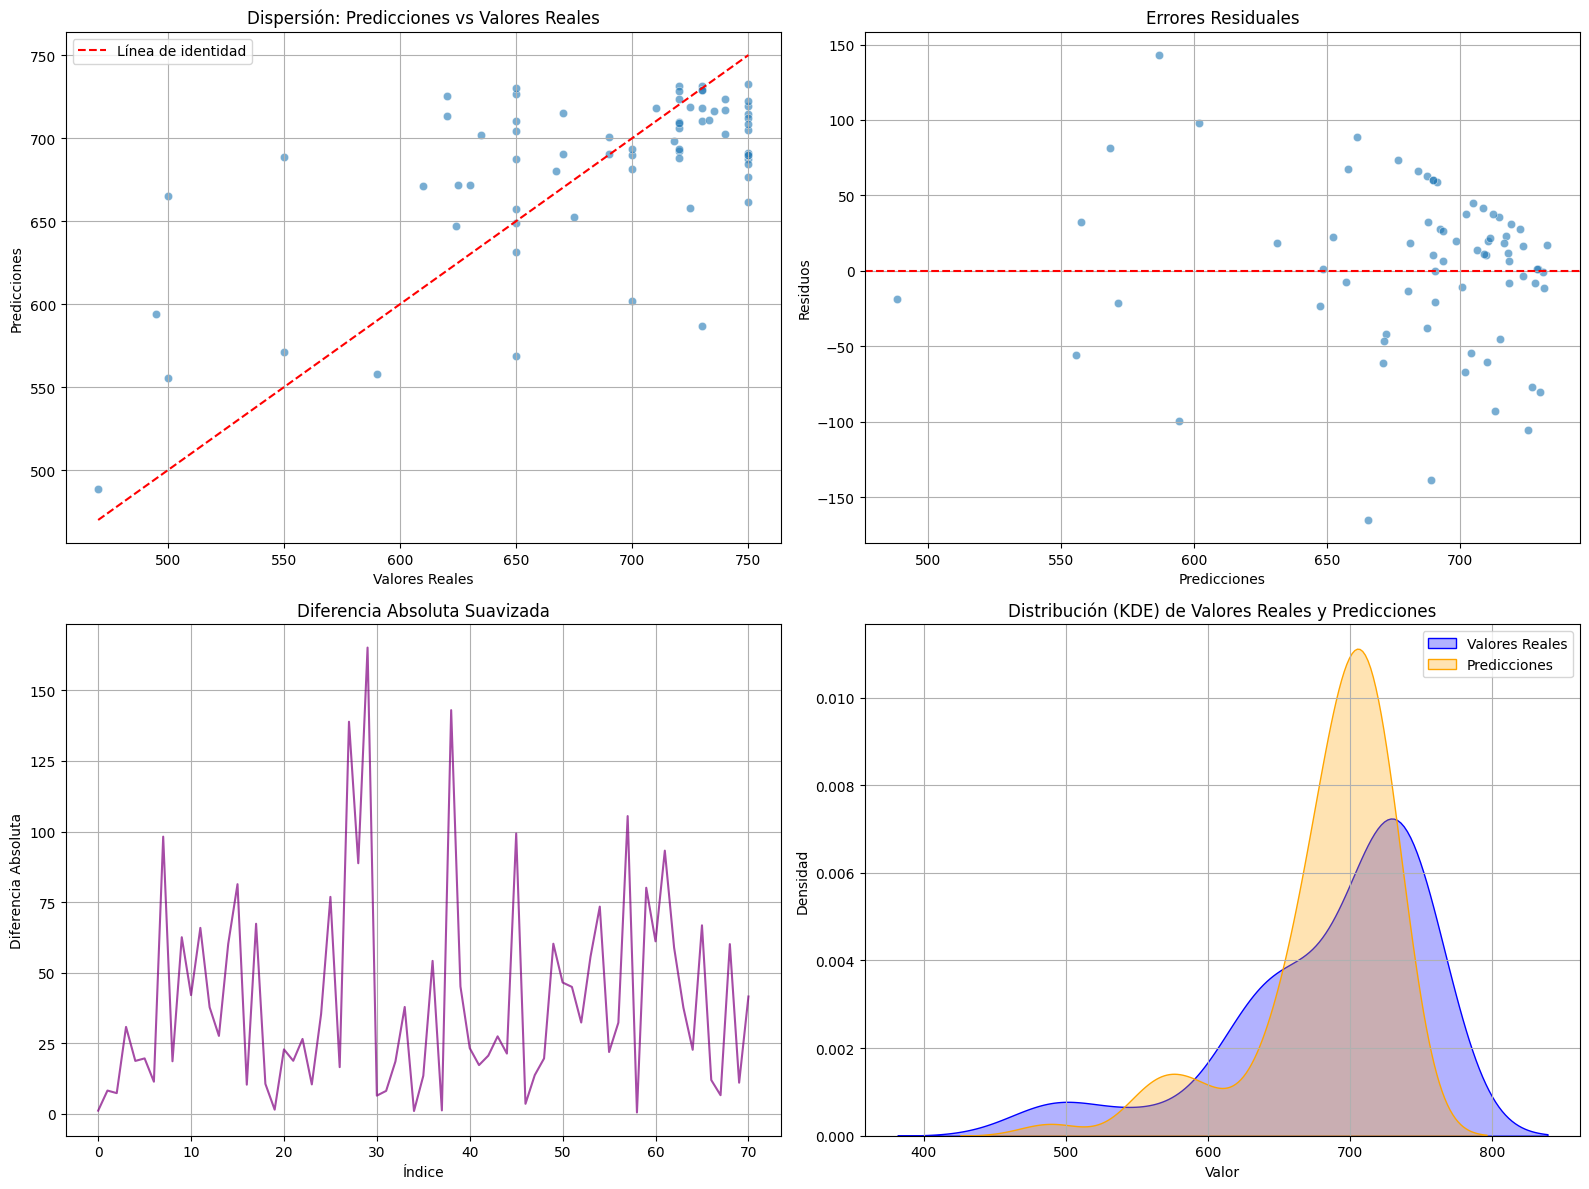

In [10]:
sp.comparativa_graficos(y_test, y_test_pred_rf)

- Dispersion: Predicciones vs Valores Reales (Arriba Izquierda):
Las predicciones siguen la tendencia general, pero con cierta dispersión, especialmente en valores bajos.
Indica que el modelo tiene problemas de ajuste para ciertos casos.
- Errores Residuales (Arriba Derecha):
Los residuales no están distribuidos uniformemente alrededor de 0, lo que sugiere que el modelo podría tener un sesgo o estar subajustado.
- Diferencia Absoluta Suavizada (Abajo Izquierda):
Se observan picos grandes en los errores absolutos, indicando que el modelo tiene dificultades con casos específicos.
- Distribución (KDE) de Valores Reales y Predicciones (Abajo Derecha):
Las distribuciones de los valores reales y predichos están cerca, pero hay diferencias notables, especialmente en los extremos.

### PROBAMOS A MEJORAR EL MODELO ELIMINANDO VARIABLES CON POCA REPERCUSIÓN

Calculamos la correlación de las variables con "Precio" para ver cuales pueden ser eliminadas por no ser representativas en el modelo

Correlaciones con 'Precio':
Precio               1.000000
Provincia            0.536239
Tiene 360            0.176591
Habitaciones         0.107024
Baños                0.105857
Tiene Plano          0.083271
Tiene Video          0.081027
Mostrar Dirección    0.046862
Tipo de Propiedad    0.036378
Ascensor             0.030791
Exterior             0.028026
Tamaño_robust       -0.076692
Distancia_robust    -0.516021
Name: Precio, dtype: float64


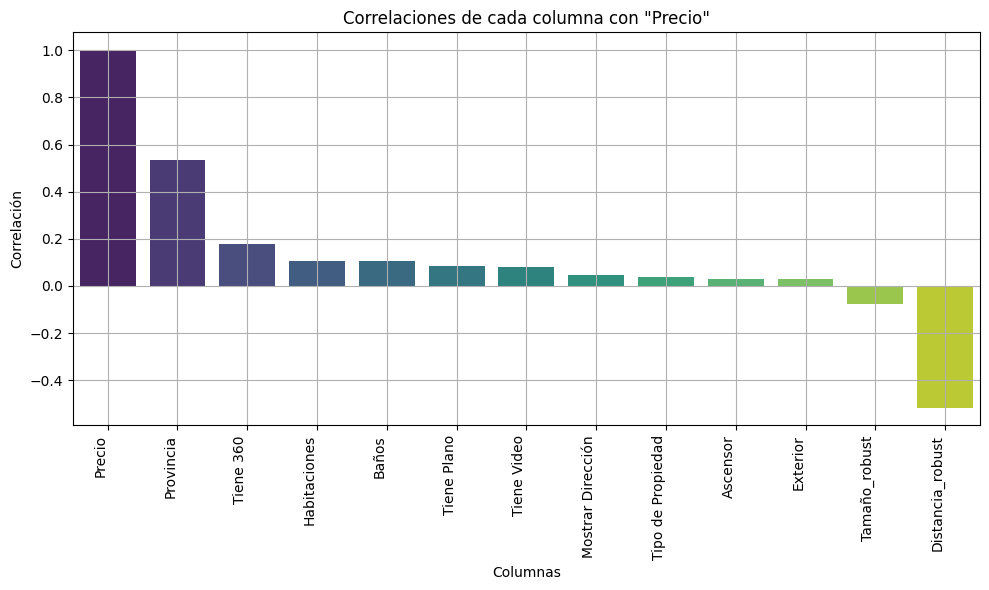


Columnas con baja correlación (abs < 0.05):
['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']


['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']

In [11]:
sp.analizar_correlaciones(df, "Precio", threshold=0.05)

In [12]:
# Excluir columnas irrelevantes según el análisis previo
columns_to_exclude = ['Mostrar Dirección', 'Tipo de Propiedad', 'Ascensor', 'Exterior']
df_filtered = df.drop(columns=columns_to_exclude)

In [13]:
# Definir las características (X) y la variable objetivo (y)
x2 = df_filtered.drop(columns=['Precio'])
y2 = df_filtered['Precio']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [16]:
# Definición de los hiperparámetros a optimizar
param_grid_rf = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 15, 20, 25],  
    'min_samples_split': [2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10],  
}

# Configuración de GridSearchCV para la optimización de hiperparámetros
model_RandomForestRegressor2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',  
    cv=10,  
    n_jobs=-1,  
)

# Entrenamiento del modelo con la búsqueda de hiperparámetros
model_RandomForestRegressor2.fit(x_train2, y_train2)

best_rf_model2 = model_RandomForestRegressor2.best_estimator_

In [17]:
y_test_pred_rf2 = best_rf_model2.predict(x_test2)
y_train_pred_rf2 = best_rf_model2.predict(x_train2)
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE
Train,0.768600,27.822800,1355.664500,36.819300
Test,0.424700,39.558700,2731.555000,52.264300
Diferenceia Train-Test,0.343900,-11.735900,-1375.890500,-15.445000
Porcentaje diferencia (%),80.974800,-42.180900,-101.492000,-41.948100
Media,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.087289,4.928894,298.976301,6.516382
Influencia dif media (%),0.050300,1.716900,201.290200,2.259600
Mediana,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.084035,4.745176,287.832359,6.273493
Influencia dif mediana (%),0.048400,1.652900,193.787400,2.175400


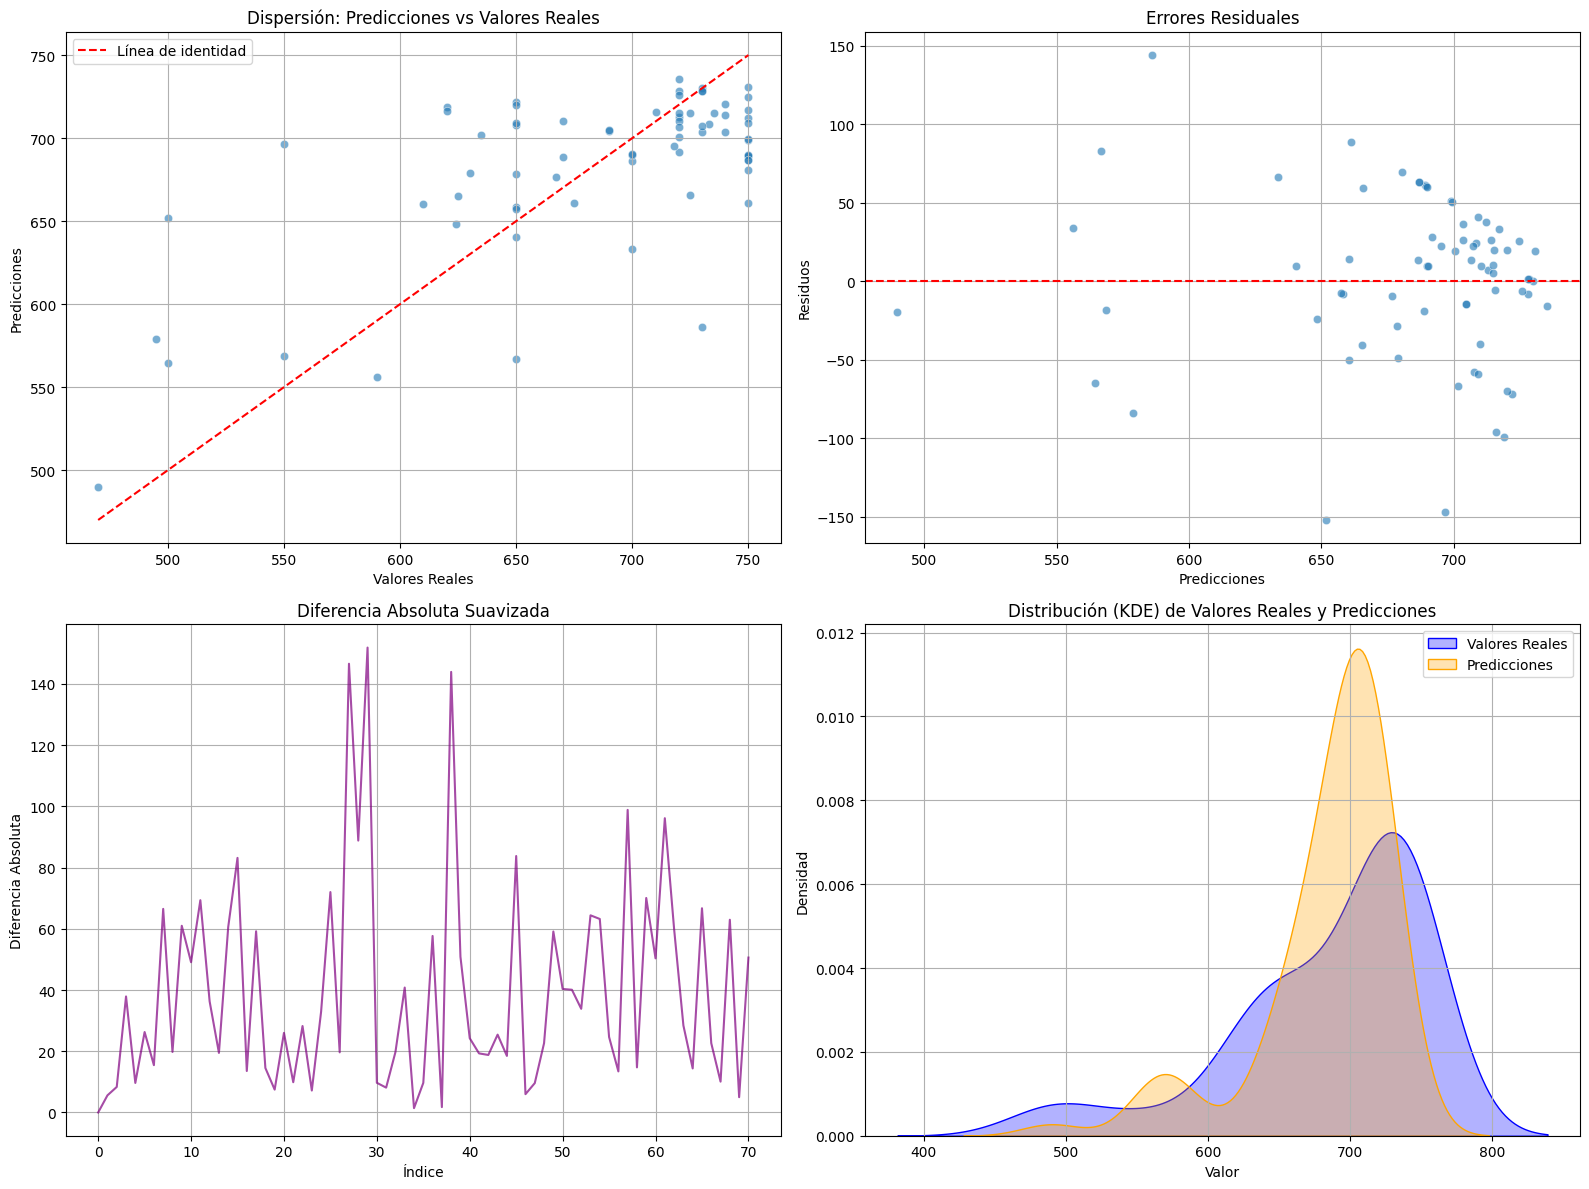

In [18]:
sp.comparativa_graficos( y_test2, y_test_pred_rf2)

#### COMPARATIVA DE METRICAS

In [19]:
sp.metricas(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

,r2_score,MAE,MSE,RMSE
Train,0.856800,21.751800,838.778500,28.961700
Test,0.384900,40.556900,2920.647000,54.043000
Diferenceia Train-Test,0.471900,-18.805100,-2081.868500,-25.081300
Porcentaje diferencia (%),122.603300,-86.453100,-248.202400,-86.601600
Media,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.090829,4.557823,274.998475,6.071717
Influencia dif media (%),0.069000,2.751200,304.573500,3.669300
Mediana,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.087444,4.387937,264.748275,5.845401
Influencia dif mediana (%),0.066500,2.648600,293.220900,3.532600


In [20]:
sp.metricas(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

,r2_score,MAE,MSE,RMSE
Train,0.768600,27.822800,1355.664500,36.819300
Test,0.424700,39.558700,2731.555000,52.264300
Diferenceia Train-Test,0.343900,-11.735900,-1375.890500,-15.445000
Porcentaje diferencia (%),80.974800,-42.180900,-101.492000,-41.948100
Media,683.535700,683.535700,683.535700,683.535700
Ratio Media(%),0.087289,4.928894,298.976301,6.516382
Influencia dif media (%),0.050300,1.716900,201.290200,2.259600
Mediana,710.000000,710.000000,710.000000,710.000000
Ratio Mediana(%),0.084035,4.745176,287.832359,6.273493
Influencia dif mediana (%),0.048400,1.652900,193.787400,2.175400


In [21]:
import pickle

# Guardar el modelo entrenado
with open('../../models/model_RandomForestRegressor2.pkl', 'wb') as file:
    pickle.dump(model_RandomForestRegressor2, file)